# Portfolio Optimization

This project mainly compares the portfolio return under rebalance method and buy and hold method. The portfolio is constructed using Markowitz portfolio model with diversification constraints.

Markowitz(1952) proved that the concept of risk is related not only with diversification, but also with direction and degree of the relationship between securities in the market. His theory called Portfolio Optimization based on average variance is being perceived as a foundation of the modern theory.

The portfolio consists of 40 stocks in the SSE 180 introduced by Shanghai Stock Exchange(SSE). The 40 stocks are selected based on historical performance and sector proportion. The chosen period is 2013 to 2014 and the monthly closing prices are collected.

Number of stocks: 40
Period: 2013 - 2014 
Price: monthly closing price
Data Source: CSMAR DATABASE


### 1. Markowitz model: 

<img src="markowitz_model.JPG",width=150,height=150>

R: required return      
x: weight

### 2. Parameter Estimiation

I estimate the mean vector and covariance matrix of the 40 stocks at the beginning of every time period. Since the future stock return is unknown, we use the past 6-month stock return data to get the mean and variance estimators. 
For buy and hold approach, I obtain optimal portfolio at the beginning of year 2013, and holding this portfolio till the end of 2014. 
For rebalancing approach, for every two months started from 2013 I rebalance the weights based on the past 6-month data.

### 3. Code

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy.optimize as sco
import matplotlib.pyplot as plt
%matplotlib inline

class InputInfo(object):
    ''' 
    
    Providing required information to calculate optimization weights
    
    Attribute
    =========
    method : string
        rebalane('Rebal') or buy and hold('B_H')
    opt_len : integer
        length of time to estimate optimized weights(month)
    reb_freq : integer
        length of time to rebalance(month)
    stockdata : DataFrame
        information of stock price
        
    Methods
    =======
    stockrets : 
        calculates stock log return 
    estimated_periods :
        divide the stock return dataframe into rolling length periods with 
        same length to estimate the optimized weights
    realized_periods :
        divide the stock return dataframe in to rebalance length of periods for 
        estimating the realized return based on the weights calculated 
        from previous periods
    gen_time_grid :
        returns the time grid for realizatio 
    get_stockrets :
        returns the stock returns dataframe
    get_esti_periods : 
        returns the estimated periods
    get_real_periods :
        returns the real periods  

    '''
    
    def __init__(self, method, opt_len, reb_freq, stockdata):
        self.method = method
        self.opt_len = opt_len
        self.reb_freq = reb_freq
        self.stockdata = stockdata
        # number of stocks
        self.stocknum = len(stockdata.columns)
    
    def stockrets(self):       
        self.stockret = np.log(self.stockdata / self.stockdata.shift(1)) 
                
    def estimated_periods(self):
        self.stockrets()
        self.esti_periods = []

        if self.method == 'B_H':
            # for buy and hold method, the estimated periods are all the same
            # which is the first estimated period
            repete_num = (len(self.stockdata.index) -1 - self.opt_len)/self.reb_freq \
                            + (len(self.stockdata.index) -1 - self.opt_len)%self.reb_freq
            i = 1
            esti_periods = self.stockret[i:(i+self.opt_len)]
            for j in range(repete_num):
                self.esti_periods.append(esti_periods)
        
        if self.method == 'Rebal':
            # for rebalance method, the estimated periods are rolling period
            # if the last period length is less than the rebalance length
            # then stop
            i = 1
            while i < (len(self.stockdata)-1):
                self.esti_periods.append(self.stockret[i:(i+self.opt_len)])
                if len(self.stockdata)-(i+self.opt_len-1)-1 <= self.reb_freq:
                    break
                else:
                    i += self.reb_freq        

    def realized_periods(self):
        # realizatio periods start from the month after the first estimated 
        # month; if the last period length is less the realization length,
        # still append it
        self.stockrets()
        self.real_periods = []
        i = self.opt_len + 1
        while i < (len(self.stockdata)-1):
            self.real_periods.append(self.stockret[i:(i+self.reb_freq)])
            if len(self.stockdata)-(i+self.reb_freq-1)-1 <= self.reb_freq:
                self.real_periods.append(self.stockret[(i+self.reb_freq):])
                break
            else:
                i += self.reb_freq
                
    def gen_time_grid(self):
        # time grid starts from the realization periods
        i = self.opt_len + self.reb_freq
        time_grid = []
        while i <= len(self.stockdata):
            time_grid.append(self.stockdata.index[i])
            i += self.reb_freq
            if i >= len(self.stockdata.index):
                # append the last period even if it is less than the 
                # realization length
                time_grid.append(self.stockdata.index[-1])
                break

        return time_grid
            
    def get_stockrets(self):
        return self.stockret
        
    def get_esti_periods(self):
        self.estimated_periods()
        return self.esti_periods
        
    def get_real_periods(self):
        self.realized_periods()
        return self.real_periods
                    

    
class OptimizeMethod(object):
    ''' 
    
    Calculating the optimized weight using Markowitz method and calculating 
        the portfolio returns
    
    Attribute
    =========
    inputinfo : class
        required information from InputInfo class
        
    Methods
    =======
    marko_weight :  
        returns the optimized weights under Markowitz minimization of 
        portfolio risks
    get_port_ret :
        returns portfolio returns over different realization periods
    get_opti_weights : 
        returns optimized weights

    '''   
    def __init__(self, inputinfo):
        self.stockret = inputinfo.stockret
        self.estiperiod = inputinfo.esti_periods
        self.realperiod = inputinfo.real_periods
        self.stocknum = inputinfo.stocknum
          
    def marko_weight(self, reqret, diver): 
        # takes the requirement return and diversification proportion on each
        # industry as parameters
        self.opti_weightlist = []
        # use to save every optimization results
        opti = []
        for i in range(len(self.estiperiod)):
            def min_func_sharpe(x):
                # objected function
                x = np.array(x)
                pret = np.sum(self.estiperiod[i].mean() * x) 
                pvol = np.sqrt(np.dot(x.T, np.dot(self.estiperiod[i].cov() , x)))
                stat_array = np.array([pret, pvol, pret/pvol])
                return stat_array[1]
            # constraints for optimization
            # total sum of weight should equal to 1
            # proportion of investing in each industry should be less than 
            # diver(e.g., 0.5)
            cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'ineq', 'fun': lambda x: \
                     np.sum(self.estiperiod[i].mean() * x) * 12 - reqret},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[:7])},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[7:11])},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[11:18])},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[18:20])},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[20:39])},
                    {'type': 'ineq', 'fun': lambda x: diver - np.sum(x[-1])})
            # bounds for optimization: each weight is between 0 and 1
            bnds = tuple((0,1) for x in range(self.stocknum))
            optivalue = sco.minimize(min_func_sharpe, self.stocknum * [1./self.stocknum,],\
                                        method = 'SLSQP', constraints = cons,\
                                        bounds = bnds) 
            opti.append(optivalue)
            # append the optimization results in which 'x' shows the weights
            self.opti_weightlist.append(opti[i]['x'])

    def get_port_ret(self):
        self.pret = []       
        for i in range(len(self.opti_weightlist)): 
            self.pret.append(np.sum(self.realperiod[i].mean() * 
                               self.opti_weightlist[i]) )
        return self.pret
    
    def get_opti_weights(self, reqreturn, diver_fac):
        self.marko_weight(reqret=reqreturn, diver=diver_fac)
        return self.opti_weightlist



### 4. Realization

#### 4.1 Stock Data and Parameters

In [2]:
# import stock data
stockdata = pd.read_csv('forty_stock.csv', index_col='Trdmnt')

# using forward fill method to fill the null value
stockdata1 = stockdata.fillna(method='ffill')

stockdata1.head()

,600109,600643,601901,601555,600837,600030,600016,600637,600804,600633,...,600300,600887,600315,600085,600418,600518,600535,600583,600276,600759
Trdmnt,,,,,,,,,,,,,,,,,,,,,
2012-02,10.24,6.29,4.38,6.73,8.34,10.66,6.39,11.54,5.46,13.89,...,3.91,20.50,30.72,13.77,6.05,11.94,36.74,5.69,26.06,6.03
2012-03,11.06,7.20,4.77,8.28,8.91,11.72,6.56,16.78,6.50,16.05,...,4.22,22.98,32.35,14.87,7.30,12.70,39.00,6.05,26.88,7.67
2012-04,11.08,7.41,4.20,7.16,8.97,11.64,6.21,14.60,6.14,18.14,...,5.86,22.10,31.50,14.19,6.15,12.64,35.70,5.51,26.10,6.23
2012-05,14.28,9.00,5.49,10.06,10.26,13.40,6.74,14.97,7.12,16.70,...,7.10,22.30,34.18,14.45,6.63,12.27,37.90,6.09,27.25,7.09
2012-06,15.46,9.33,5.23,9.75,10.47,13.77,6.37,14.56,6.75,15.53,...,9.17,22.48,36.56,15.00,6.66,12.65,38.80,6.16,26.10,5.98


In [3]:
# estimate period and realized_period
estimate_period = 6
realized_period = 2

# required return and diversification constraints
req_return = 0.01
diver = 0.5

#### 4.2 Rebalance Method

In [4]:
rebal = InputInfo('Rebal',estimate_period,realized_period,stockdata1)

In [5]:
# the estimated periods for rebalance method
rebal.get_esti_periods()[0:1]

[           600109    600643    601901    601555    600837    600030    600016  \
 Trdmnt                                                                          
 2012-03  0.077033  0.135120  0.085298  0.207268  0.066111  0.094798  0.026256   
 2012-04  0.001807  0.028749 -0.127262 -0.145333  0.006711 -0.006849 -0.054830   
 2012-05  0.253718  0.194394  0.267844  0.340057  0.134367  0.140807  0.081899   
 2012-06  0.079396  0.036010 -0.048517 -0.031300  0.020261  0.027238 -0.056460   
 2012-07 -0.067562 -0.116980 -0.031070 -0.104791 -0.077420 -0.088002 -0.058175   
 2012-08 -0.226610 -0.040571 -0.130437 -0.065906 -0.008290 -0.028964  0.000000   
 
            600637    600804    600633    ...       600300    600887    600315  \
 Trdmnt                                   ...                                    
 2012-03  0.374368  0.174353  0.144540    ...     0.076298  0.114199  0.051700   
 2012-04 -0.139166 -0.056977  0.122411    ...     0.328314 -0.039047 -0.026626   
 2012-05  0.02

In [6]:
# the realization periods for rebalance method
rebal.get_real_periods()[0:1]

[           600109    600643    601901    601555    600837    600030    600016  \
 Trdmnt                                                                          
 2012-09  0.011222 -0.025414 -0.089261 -0.145068 -0.159890 -0.188052 -0.030408   
 2012-10  0.265331 -0.002577  0.052644  0.170295  0.156764  0.149778 -0.034908   
 
            600637    600804    600633    ...       600300    600887    600315  \
 Trdmnt                                   ...                                    
 2012-09  0.074210  0.003367  0.037820    ...    -0.131697  0.068354  0.050170   
 2012-10  0.069699  0.091483  0.025782    ...     0.081621  0.055086  0.044374   
 
            600085    600418    600518    600535    600583    600276    600759  
 Trdmnt                                                                         
 2012-09 -0.021152 -0.066249 -0.017652  0.067252 -0.045542  0.051101  0.030483  
 2012-10  0.025793  0.152192  0.078988  0.043745 -0.009001  0.006290  0.092577  
 
 [2 rows x 40 

In [7]:
rebal_opt = OptimizeMethod(rebal)

# optimized weights for rebalance method
weight_rebal = rebal_opt.get_opti_weights(req_return, diver)

In [8]:
weight_rebal[0:2]

[array([  4.83284769e-17,   9.81325332e-18,   9.20238351e-17,
          2.66670597e-18,   0.00000000e+00,   3.18774988e-17,
          3.84664761e-16,   1.85808034e-02,   1.09021961e-16,
          3.24213421e-01,   1.28238512e-16,   1.58606606e-18,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.57205775e-01,   0.00000000e+00,   1.04872638e-17,
          1.61771114e-16,   0.00000000e+00,   1.20774431e-01,
          7.64316881e-17,   0.00000000e+00,   1.45525446e-17,
          9.10762872e-18,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.12890498e-17,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.48327027e-01,
          0.00000000e+00,   9.90435702e-18,   1.74782954e-16,
          3.08985419e-02,   4.72717743e-18,   0.00000000e+00,
          1.68787165e-17]),
 array([  0.00000000e+00,   3.07119140e-17,   1.16237397e-16,
          7.70248925e-17,   1.30253408e-16,   1.21793249e-16,
          1.87982273e-01,   0.00000000e+00

In [9]:
# portfolio return for the realization periods
port_ret_rebal = rebal_opt.get_port_ret()

In [10]:
port_ret_rebal

[0.02218096886222644,
 -0.04040353767369374,
 0.1447991314193075,
 -0.004907833953748835,
 0.12198324191645814,
 0.051019752366384716,
 0.1249138150971342,
 -0.04174299770678517,
 -0.0247290117569027,
 -0.01430637720657735,
 -0.0009888993407382671,
 0.025350925253278866,
 0.04585144326138431,
 0.02736938472370824,
 0.04154174455267907]

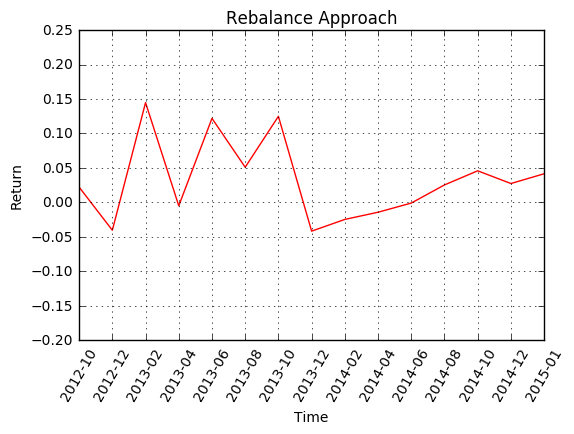

In [11]:
# plot of the rebalance method return
timegrid= rebal.gen_time_grid()

x = np.array(range(15))
y_rebal = np.array(port_ret_rebal)
my_xticks = timegrid
plt.xticks(x, my_xticks,rotation=60)
plt.plot(x, y_rebal,color='r')
plt.title('Rebalance Approach')
plt.ylabel('Return')
plt.xlabel('Time')
plt.grid()
plt.gca().set_ylim([-0.20,0.25])
plt.show()

#### 4.3 Buy-and-Hold Method

In [12]:
bh = InputInfo('B_H',estimate_period,realized_period,stockdata1)

# the estimated periods for buy and hold method
bh.get_esti_periods()[0:1]

[           600109    600643    601901    601555    600837    600030    600016  \
 Trdmnt                                                                          
 2012-03  0.077033  0.135120  0.085298  0.207268  0.066111  0.094798  0.026256   
 2012-04  0.001807  0.028749 -0.127262 -0.145333  0.006711 -0.006849 -0.054830   
 2012-05  0.253718  0.194394  0.267844  0.340057  0.134367  0.140807  0.081899   
 2012-06  0.079396  0.036010 -0.048517 -0.031300  0.020261  0.027238 -0.056460   
 2012-07 -0.067562 -0.116980 -0.031070 -0.104791 -0.077420 -0.088002 -0.058175   
 2012-08 -0.226610 -0.040571 -0.130437 -0.065906 -0.008290 -0.028964  0.000000   
 
            600637    600804    600633    ...       600300    600887    600315  \
 Trdmnt                                   ...                                    
 2012-03  0.374368  0.174353  0.144540    ...     0.076298  0.114199  0.051700   
 2012-04 -0.139166 -0.056977  0.122411    ...     0.328314 -0.039047 -0.026626   
 2012-05  0.02

In [13]:
# the realization periods for buy and hold method
bh.get_real_periods()[0:1]

[           600109    600643    601901    601555    600837    600030    600016  \
 Trdmnt                                                                          
 2012-09  0.011222 -0.025414 -0.089261 -0.145068 -0.159890 -0.188052 -0.030408   
 2012-10  0.265331 -0.002577  0.052644  0.170295  0.156764  0.149778 -0.034908   
 
            600637    600804    600633    ...       600300    600887    600315  \
 Trdmnt                                   ...                                    
 2012-09  0.074210  0.003367  0.037820    ...    -0.131697  0.068354  0.050170   
 2012-10  0.069699  0.091483  0.025782    ...     0.081621  0.055086  0.044374   
 
            600085    600418    600518    600535    600583    600276    600759  
 Trdmnt                                                                         
 2012-09 -0.021152 -0.066249 -0.017652  0.067252 -0.045542  0.051101  0.030483  
 2012-10  0.025793  0.152192  0.078988  0.043745 -0.009001  0.006290  0.092577  
 
 [2 rows x 40 

In [14]:
bh_opt = OptimizeMethod(bh)

# optimized weights for buy and hold method
weight_bh = bh_opt.get_opti_weights(req_return, diver)

In [15]:
weight_bh[0:2]

[array([  4.83284769e-17,   9.81325332e-18,   9.20238351e-17,
          2.66670597e-18,   0.00000000e+00,   3.18774988e-17,
          3.84664761e-16,   1.85808034e-02,   1.09021961e-16,
          3.24213421e-01,   1.28238512e-16,   1.58606606e-18,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.57205775e-01,   0.00000000e+00,   1.04872638e-17,
          1.61771114e-16,   0.00000000e+00,   1.20774431e-01,
          7.64316881e-17,   0.00000000e+00,   1.45525446e-17,
          9.10762872e-18,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.12890498e-17,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.48327027e-01,
          0.00000000e+00,   9.90435702e-18,   1.74782954e-16,
          3.08985419e-02,   4.72717743e-18,   0.00000000e+00,
          1.68787165e-17]),
 array([  4.83284769e-17,   9.81325332e-18,   9.20238351e-17,
          2.66670597e-18,   0.00000000e+00,   3.18774988e-17,
          3.84664761e-16,   1.85808034e-02

In [16]:
# portfolio return for the realization periods
port_ret_bh = bh_opt.get_port_ret()

port_ret_bh

[0.02218096886222644,
 -0.0372400796086905,
 0.12189517112939095,
 0.04421004734333461,
 -0.03501452138383173,
 0.10523927987715068,
 0.06774902399205746,
 -0.1194074242972782,
 -0.00911804745449721,
 -0.047695705947541384,
 -0.12909195246374777,
 0.015175003613887236,
 0.07580441391363699,
 -0.0022831469215898333,
 0.05786646635935191]

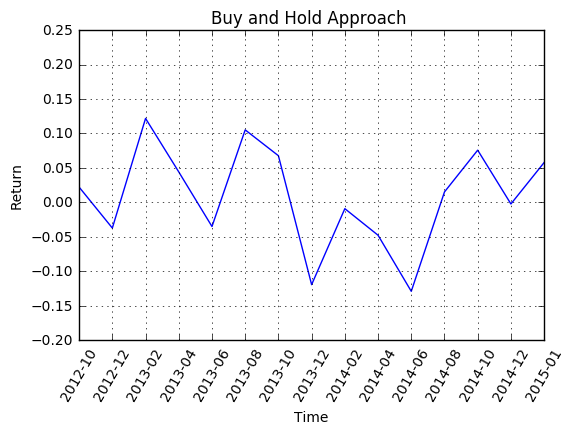

In [17]:
# plot of the buy and hold method return

x = np.array(range(15))
y_bh = np.array(port_ret_bh)
my_xticks = timegrid
plt.xticks(x, my_xticks,rotation=60)
plt.plot(x, y_bh,color='b')
plt.title('Buy and Hold Approach ')
plt.ylabel('Return')
plt.xlabel('Time')
plt.grid()
plt.gca().set_ylim([-0.20,0.25])
plt.show()

#### 4.4 Comparison and Conclusion

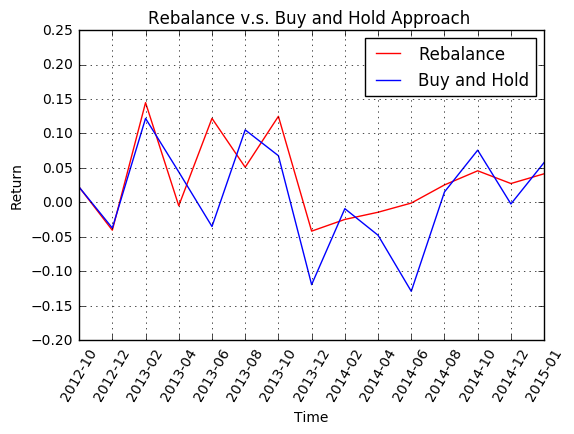

In [18]:
# plot of returns for both method
plt.xticks(x, my_xticks,rotation=60)
plt.plot(x, y_rebal,color='r',label='Rebalance' )
plt.plot(x, y_bh, color='b', label='Buy and Hold')
plt.gca().set_ylim([-0.20,0.25])
plt.legend()
plt.title('Rebalance v.s. Buy and Hold Approach ')
plt.ylabel('Return')
plt.xlabel('Time')
plt.grid()
plt.show()

From the graph of returns under these two method, we can roughly see that the portfolio performance is overall better under rebalance approach.

In [19]:
# mean return comparison
comparison = ((np.array(port_ret_rebal) - np.array(port_ret_bh))).mean()

comparison

0.023177483520017049

After calculating the mean return difference between these two approach, the average return under rebalance approach is 2.318% higher than under buy and hold approach.

Since the previous six-month history data is used predict later two-month holding proportion, it turns out that the proportion prediction of the portfolio is much closed to the corresponding securities’ realized performance.

In conclusion, under Markowitz Portfolio Optimization method, the rebalance approach and buy and hold approach are compared. It turns out that the rebalance approach contributes to better portfolio performance. However, there are still some limitation of this approach since some other constraints have not been considered such as transaction costs.